In [1]:
%run RDV.ipynb

The following cell shows an example of usage of the  class `LookAheadStrategy`. 
It creates an instance of this strategy with $h=L=2$ the params given in the paper.
The meeting-time is computed for each of the worst-case distances. Then, the competitive ratio is the largest of the $L=2$ returned values.

In [2]:
lhs = LookAheadStrategy(2,2,alpha=1.2141,p={(0,1):0.432,(1,0):1,(1,1):0.683})
D = lhs.worst_case_distances()

print('meeting times at each value d of D:')
print([lhs.meeting_time(d,method=2) for d in D])
print('competitive ratio:', lhs.competitive_ratio())

meeting times at each value d of D:
[20.305923775434582, 20.30526395379082]
competitive ratio: 20.305923775434582


The following does the same thing for $h=L=4$, but used the best-found parameters stored in the subfolder `/optima`

In [3]:
h = 4
L = 4
lhs = LookAheadStrategy(h,L,optimized=True)

D = lhs.worst_case_distances()

print('meeting times at each value d of D:')
print([lhs.meeting_time(d,method=2) for d in D])
print('competitive ratio:', lhs.competitive_ratio())

meeting times at each value d of D:
[15.01545194942756, 15.015469807897729, 14.402528085815028, 14.886352183403224]
competitive ratio: 15.015469807897729


The following cell performs a Monte-Carlo simulation with the above strategy, which converges
to the same value (after a long time).

In [4]:
#define custom progressbar (requires pip package `progressbar2`)
import progressbar
display_simulation = progressbar.FormatCustomText('MC simulation for d=1: %(montecarlo)f'\
                                                  ' ± %(width)f'
                                                  ,dict(montecarlo=100,width=10))
bar = progressbar.progressbar(range(500000),
                              widgets=['[',progressbar.Percentage(),
                                       ']  ',
                                       progressbar.Bar(),
                                       '  ',
                                       progressbar.ETA(),
                                       ' | ',
                                       display_simulation])

#run the Monte-Carlo simulation
d = 1.+1e-6
hits = []
for run_it in bar:
    hits.append(lhs.simulate(d))
    if run_it % 100 == 0:
        display_simulation.update_mapping(montecarlo=np.mean(hits),
                                          width= np.std(hits)/(1e-10+run_it)**0.5
                                         )

[100%]  |#######|  Time:  0:07:35 | MC simulation for d=1: 15.024607 ± 0.034203


Now, let's load the best-found strategy with $h=L=7$:

In [5]:
h = 7
L = 7
lhs = LookAheadStrategy(h,L,optimized=True)
D = lhs.worst_case_distances()
print([lhs.meeting_time(d) for d in D])

[13.511329975942397, 13.40647385949053, 13.51947660577056, 13.457987340040015, 13.177535939028326, 13.153613701111128, 13.267810109309183]


We round $\alpha$ and the switching probabilities for the sake of readability (this is the policy displayed in the paper)

In [6]:
ar = np.round(lhs.alpha,4)
pr = {k:np.round(v,3) for k,v in lhs.p.items()}
lhs.initialize_MarkovChain_with_params(ar,pr)
Dr = lhs.worst_case_distances()
for d in Dr:
    print(d, lhs.meeting_time(d))

1.0000001 13.51003058263013
2.1396001000000004 13.406085529803574
3.4382882599999998 13.519692673817213
4.918273287136 13.4585731536062
6.604864224060185 13.178382529597396
8.526903255778985 13.154686530688108
10.717258936325731 13.26911493834697


Next, we plot the competitive ratio against the unknown distance $d$. To do this, we compute the competitive ratio for several values in each interval between 2 breakpoints of the function, between 1 and $\alpha$.

In [7]:
#compute the worst-case distances that fall in the interval [1,alpha]
#and the corresponding index shift i  such that di = ell_i^\delta
D1alpha = []
iialpha = []
for d in Dr:
    di = d
    i = 0
    while di>lhs.alpha:
        di/=lhs.alpha
        i -= 1
    iialpha.append(i)
    D1alpha.append(di)

#compute roughly N points (up to rounding) `aaa`, uniformly distributed  in each interval around
#worst case distances
break_points = sorted(D1alpha) + [lhs.alpha]
N=30
aaa = []
for a,b in zip(break_points[:-1],break_points[1:]):
    k = max(3,int(np.ceil((b-a)/(lhs.alpha-1)*N)))
    aaa.extend(np.linspace(a,b-1e-7,k))
    
print(f'compute meeting time for {len(aaa)} values of d')
    
yyy = []
for it,d in enumerate(aaa):
    y = lhs.meeting_time(d)
    print(f'{it}/{len(aaa)}: meeting_time({d})={y}')
    yyy.append(y)

compute meeting time for 39 values of d
0/39: meeting_time(1.0000001)=13.51003058263013
1/39: meeting_time(1.0049646007993704)=13.44823133439968
2/39: meeting_time(1.009929101598741)=13.38703965835772
3/39: meeting_time(1.0148936023981117)=13.326446638419036
4/39: meeting_time(1.019858103197482)=13.26644353210653
5/39: meeting_time(1.019858203197482)=13.269114938346974
6/39: meeting_time(1.0224992764510534)=13.237424322954922
7/39: meeting_time(1.0251403497046248)=13.205896996885599
8/39: meeting_time(1.0251404497046248)=13.4585731536062
9/39: meeting_time(1.0299146356303368)=13.40082123655727
10/39: meeting_time(1.0346888215560488)=13.343602268901078
11/39: meeting_time(1.0394630074817606)=13.28690890723202
12/39: meeting_time(1.0442371934074726)=13.230733942438821
13/39: meeting_time(1.0490113793331846)=13.175070296648594
14/39: meeting_time(1.0537855652588966)=13.119911020253937
15/39: meeting_time(1.0537856652588966)=13.154686530688107
16/39: meeting_time(1.056921902751645)=13.1186

Populating the interactive namespace from numpy and matplotlib


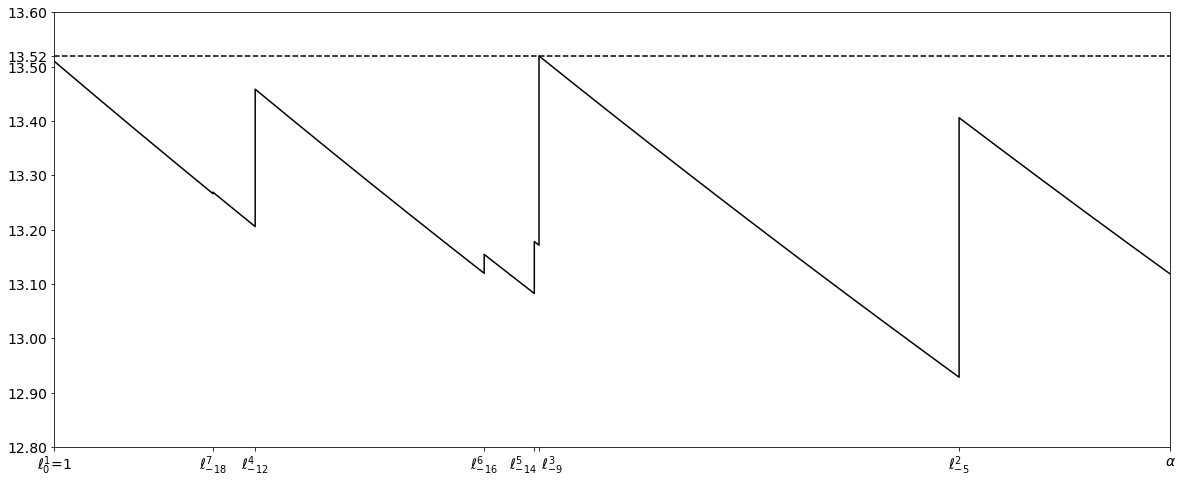

In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 8)
plot(aaa,yyy,'k')
locations = [lhs.ell(iialpha[delta],delta+1) for delta in range(L)]+[lhs.alpha]
labels = [f'$\ell_{{{iialpha[delta]}}}^{delta+1}$'for delta in range(L)]+['$\\alpha$']
labels[0]+='=1'
labels[2]='      '+labels[2]
labels[4]+='      '
CR = 13.52
plot([1,lhs.alpha],[CR,CR],'k--')
xticks(locations, labels,fontsize=14)
xlim(1,lhs.alpha)
yloc,ylab = yticks()
yticks(list(yloc)+[CR],fontsize=14)
savefig('CR_vs_d.png',dpi=300,bbox_inches='tight')

This cell was used to generate the latex code with the strategy's switching probabilities 

In [9]:
pp = lhs.p

cols = 6

#header
tex = '\\begin{tabular}{'+ '@{\hskip 5mm}'.join(['cc']*cols) +'}\n'
tex += '\hline\n'
tex += ' & '.join(['$\sigma$ & $p_\sigma$']*cols) + '\\\\\hline\n'

#rows
row=0
for ik,k in enumerate(sorted(lhs.turn_states)):
    icol = ik%cols
    tex += ''.join(str(ki) for ki in k) + ' & ' + f'{pp[k]:.3f}'
    if icol == cols-1:
        if row==0:
            tex+='\Tstrut'
        tex += '\\\\\n'
        row+=1
    else:
        tex += ' & '

tex+='\\\\\n'
tex+='\hline\n'
tex+='\end{tabular}'

f = open('opt_lookahead.tex','w')
f.write(tex)
f.close()
print(tex)


\begin{tabular}{cc@{\hskip 5mm}cc@{\hskip 5mm}cc@{\hskip 5mm}cc@{\hskip 5mm}cc@{\hskip 5mm}cc}
\hline
$\sigma$ & $p_\sigma$ & $\sigma$ & $p_\sigma$ & $\sigma$ & $p_\sigma$ & $\sigma$ & $p_\sigma$ & $\sigma$ & $p_\sigma$ & $\sigma$ & $p_\sigma$\\\hline
0000001 & 0.033 & 0000010 & 0.166 & 0000011 & 0.057 & 0000100 & 0.105 & 0000101 & 0.362 & 0000110 & 1.000\Tstrut\\
0000111 & 0.828 & 0001000 & 0.179 & 0001001 & 1.000 & 0001010 & 0.812 & 0001011 & 0.065 & 0001100 & 0.421\\
0001101 & 0.017 & 0001110 & 0.191 & 0001111 & 0.638 & 0010000 & 0.247 & 0010001 & 0.997 & 0010010 & 0.997\\
0010011 & 0.000 & 0010100 & 1.000 & 0010101 & 0.003 & 0010110 & 0.000 & 0010111 & 0.000 & 0011000 & 0.499\\
0011001 & 0.896 & 0011010 & 0.021 & 0011011 & 0.000 & 0011100 & 0.000 & 0011101 & 0.997 & 0011110 & 0.130\\
0011111 & 0.262 & 0100000 & 0.477 & 0100001 & 0.997 & 0100010 & 1.000 & 0100011 & 0.003 & 0100100 & 0.000\\
0100101 & 0.003 & 0100110 & 0.000 & 0101000 & 0.003 & 0101001 & 0.000 & 0101010 & 0.000 & 010

In [10]:
lhs.alpha

1.1396